## 1.  Data load and visulization

In [43]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
import tensorflow as tf

In [8]:
df = pd.read_csv('stage_2_train_labels.csv')
print(df.iloc[0])
print(df.iloc[4])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object
patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


In [3]:
patientId = df['patientId'][0] # select first patient ID
dcm_file = 'D:\Kaggle\ImageClassification/train_images/%s.dcm' % patientId # select first dcm file based on patient ID
dcm_data = pydicom.read_file(dcm_file)

#print(dcm_data)

In [4]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

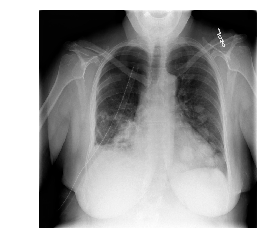

In [10]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [9]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = { }
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': 'D:\Kaggle\ImageClassification/train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [10]:
parsed = parse_data(df)

In [7]:
print(df.iloc[4])
parsed['00436515-870c-4b36-a041-de91049b9ab4']

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


{'dicom': 'D:\\Kaggle\\ImageClassification/train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'label': 1,
 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}

In [8]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom']) # data['dicom'] is the absolute address of dicom file
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2) # 1024 x 1024 size list x 3, after stack = 1024 x 1024 x 3

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    # Draw the box in original figure
    im[y1:y1 + stroke, x1:x2] = rgb # change the pixel value in this box area into a randon rgb value
    im[y2:y2 + stroke, x1:x2] = rgb # draw a orizontal line in y2
    im[y1:y2, x1:x1 + stroke] = rgb # draw a vertical line in x1
    im[y1:y2, x2:x2 + stroke] = rgb # draw a vertical line in x2

    return im

In [62]:
print(df.iloc[8])

patientId    00704310-78a8-4b38-8475-49f4573b2dbb
x                                             323
y                                             577
width                                         160
height                                        104
Target                                          1
Name: 8, dtype: object


{'dicom': 'D:\\Kaggle\\ImageClassification/train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm', 'label': 1, 'boxes': [[577.0, 323.0, 104.0, 160.0], [575.0, 695.0, 137.0, 162.0]]}


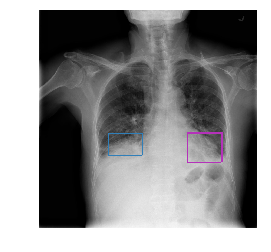

In [63]:
print(parsed['00704310-78a8-4b38-8475-49f4573b2dbb'])
draw(parsed['00704310-78a8-4b38-8475-49f4573b2dbb'])

In [11]:
df_detailed = pd.read_csv('D:\Kaggle\ImageClassification/stage_2_detailed_class_info\stage_2_detailed_class_info.csv')
print(df_detailed.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


In [12]:
summary = { }
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
print(summary)

{'No Lung Opacity / Not Normal': 11821, 'Normal': 8851, 'Lung Opacity': 9555}


In [11]:
parsed['00436515-870c-4b36-a041-de91049b9ab4']

{'dicom': 'D:\\Kaggle\\ImageClassification/train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'label': 1,
 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}

In [12]:
raw_data = []
patientId = []
for id in df['patientId']:
    paId = df['patientId'][id]
    if paId not in patientId:
        patientId.append(paId)
        
   # dcm_file = 'D:\Kaggle\ImageClassification/train_images/%s.dcm' % paId # select first dcm file based on patient ID
   # dcm_data = pydicom.read_file(dcm_file)

   # im = dcm_data.pixel_array

KeyError: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'

## 2. Data processing

In [57]:
import os
import random
# load and shuffle filenames
folder = 'D:\Kaggle\ImageClassification/train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


In [61]:
train_filenames[0:5]

['659b4b06-6273-4efb-85fb-93e014d1ca2f.dcm',
 '92097b0f-44d8-4358-937d-cbf8c34c0732.dcm',
 '65b5430c-faff-4993-a138-f2cb1fb2ad06.dcm',
 '41bf38ed-29d0-4ac1-8e2f-a1a1d6468856.dcm',
 'c3713d1a-6d8e-47c8-ae09-6ae3a5cfc72d.dcm']